# Figures

In [1]:
%load_ext autoreload
%autoreload 2

import collections
import os
import pathlib
import pickle

import joblib
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

if 'project_dir' not in globals():
  project_dir = pathlib.Path.cwd().parent
os.chdir(project_dir)

import src.network.distance_distribution
from src.network.cooccurrence import Cooccurrence
import src.network.degree_histogram
import src.network.modularity
import src.network.giant_component
import src.progress_parallel

data_file = 'data/3-process/data.pkl'
network_file = 'networks/8/graph_attributes.pkl'
dutch_network_file = 'networks/8/dutch_graph_attributes.pkl'
giant_component_file = 'networks/8/giant_component.pkl'
dutch_data_file = 'data/3-process/rdw.pkl'
figure_file = 'reports/Fig'
distance_distribution_file = 'networks/8/distance_distribution.txt'



## Figure 5

In [2]:
from community import best_partition, modularity

with open(network_file, 'rb') as file:
    g = pickle.load(file)
gc = src.network.giant_component.giant_component(g)

resolutions = [5e-3, .01, .02, .05, .1, .2, .5, 1, 2]
partitions = {
    r: best_partition(gc, resolution=r) 
    for r in tqdm(resolutions)
}


  0%|          | 0/9 [00:00<?, ?it/s]

## Figure 5d
This score could be improved by using the degree and strength assortativity as well.
This was not done in the original paper.

In [6]:
def get_assortativity_per_community(
        gc: nx.Graph, nodes: list[str], attribute: str):
    if attribute in ['degree', 'strength']:
        weight = 'weight' if 'strength' else None
        if len(nodes) > 2:
            return nx.degree_assortativity_coefficient(
                gc, nodes=nodes, weight=weight)
    else:
        if len(nodes) > 2:
            x = nx.attribute_assortativity_coefficient(
                gc, attribute, nodes=nodes)
            if x is np.nan and attribute == 'country':
                    return 1
            else:
              return x

communities_per_resolution = dict()
for resolution, partition in partitions.items():
    communities = collections.defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    communities_per_resolution[resolution] = communities
    
iterable = [
    (resolution, community_id, nodes, attribute)
    for resolution, communities in communities_per_resolution.items()
    for community_id, nodes in communities.items()
    for attribute in [
        'degree', 'strength', 'country', 'v_median', 'nl', 'l_max']
]

assortativities_per_community = {
  (resolution, community_id, attribute): 
  get_assortativity_per_community(gc, nodes, attribute) 
  for resolution, community_id, nodes, attribute in tqdm(iterable)
}

assortativity_table = (
  pd.Series(assortativities_per_community).unstack().fillna(1).abs())

average_maximal_community_assortativity = {
  resolution: assortativity_table.loc[resolution].max(axis=1).mean() 
  for resolution in resolutions
}     

  0%|          | 0/46020 [00:00<?, ?it/s]

/local/bruingjde/conda_envs/gj/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:263: RuntimeWarning: invalid value encountered in double_scalars
  r = (t - s) / (1 - s)


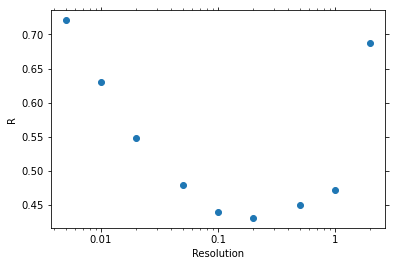

In [7]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    pd.Series(average_maximal_community_assortativity).plot(marker='o', ls='', logx=True, xlabel='Resolution', ylabel='R')
    plt.xticks([.01, .1, 1], [.01, .1, 1])
    plt.savefig(figure_file + '5d.pdf')

## Table A1

In [10]:
assortativity_table.loc[2].idxmax().sort_values(ascending=False)

degree      88
strength    88
v_median    50
l_max       16
nl           8
country      0
dtype: int64